# pivpy example

In [1]:
import os, sys
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
sys.path.append('../../')

In [3]:
from pivpy import io, graphics, process

In [4]:
filename = '../data/Run000001.T000.D000.P000.H001.L.vec'

variables, units, rows, cols = io.parse_header(filename)
data = io.loadvec(filename,rows,cols)

In [5]:
d = np.loadtxt(filename,skiprows=1,delimiter=',',usecols=(0,1,2,3,4)).reshape(rows,cols,5)

In [6]:
u = xr.DataArray(d[:,:,2],dims=('x','y'),coords={'x':d[:,:,0][0,:],'y':d[:,:,1][:,0]})
v = xr.DataArray(d[:,:,3],dims=('x','y'),coords={'x':d[:,:,0][0,:],'y':d[:,:,1][:,0]})
cnc = xr.DataArray(d[:,:,4],dims=('x','y'),coords={'x':d[:,:,0][0,:],'y':d[:,:,1][:,0]})
data = xr.Dataset({'u': u, 'v': v,'cnc':cnc})           

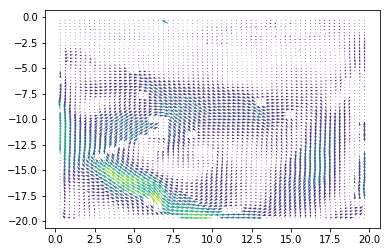

In [7]:
plt.figure()
plt.quiver(data.x,data.y,data.u,data.v,data.u**2 + data.v**2)

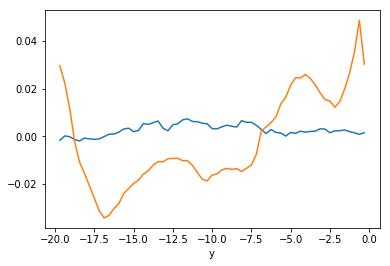

In [8]:
# profile along y
data.mean(dim='x').to_dataframe()['u'].plot()
data.mean(dim='x').to_dataframe()['v'].plot()

In [9]:
def filterf(data):
    """Gaussian filtering of velocity """
    from scipy.ndimage.filters import gaussian_filter as gf
    data['u'] = xr.DataArray(gf(data['u'],1),dims=('x','y'))
    data['v'] = xr.DataArray(gf(data['v'],1),dims=('x','y'))
    return data

In [10]:
data = filterf(data)

In [11]:
# adding frames
data = xr.concat([data, data], 't')

In [12]:
# averf:
data.mean(dim='t')

<xarray.Dataset>
Dimensions:  (x: 63, y: 63)
Coordinates:
  * x        (x) float64 0.3125 0.625 0.9374 1.25 1.562 1.875 2.187 2.5 ...
  * y        (y) float64 -0.3125 -0.625 -0.9374 -1.25 -1.562 -1.875 -2.187 ...
Data variables:
    u        (x, y) float64 5.376e-05 5.337e-05 5.602e-05 6.373e-05 ...
    v        (x, y) float64 1.852e-05 2.208e-05 2.544e-05 2.453e-05 ...
    cnc      (x, y) float64 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 ...

In [13]:
# prepare space
data['w'] = xr.DataArray(np.zeros_like(data['u']),dims=['t','x','y'])
# estimate curl
for t in data.t:
    tmp = data.isel(t=t)
    ux,uy = np.gradient(tmp['u'])
    vx,vy = np.gradient(tmp['v'])
    tmp['w'] += vy - ux

In [14]:
# get the list of variables
set(data.keys()) - set(data.coords)

/Users/alex/miniconda3/lib/python3.6/_collections_abc.py:720: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  yield from self._mapping


{'cnc', 'u', 'v', 'w'}

In [15]:
tmp = process.vec2scal(data,'curl')

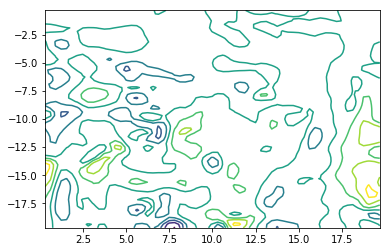

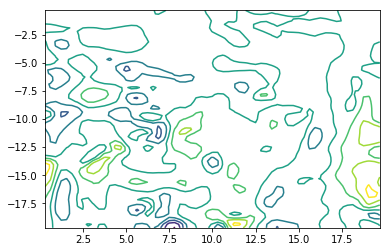

In [16]:
graphics.showscal(tmp)